# Test system for function development

In [1]:
# DO NOT MODIFY BELOW

# File Handling
import os
import pickle

# Array Handling
import numpy as np
import pandas as pd

# Make Plotting Interactive
from ipywidgets import interact, fixed

# Wrapper for xraylarch (larch)
os.chdir('..')
pwd = os.getcwd()
os.chdir('./catxas')
import general as fcts
import xas as xfcts
import plot as pfcts
import process
import experiment as exp

# Plot Handling
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
# Where is the data?

# Directory Containing Experiment:
pickle_dir = r'D:\UU QEXAFS Workup\Nina - BF31\Fe Edge\Up\Results\Step B'

# Name of Experiment (must include extension '.pickle')
pickle_name = 'BF31-Fe-B.pickle'


In [3]:
# DO NOT MODIFY BELOW

pickle_path = os.path.join(pickle_dir,pickle_name)
pickle_in = open(pickle_path,"rb")
my_exp = pickle.load(pickle_in)
pickle_in.close()

# Method for Averaging (merging) Spectra


In [4]:
# List all Spectra in experiment

spectra_list = list(my_exp.spectra.keys())

spectra_list

['20211119_ME_BF31_Fe_B_00003',
 '20211119_ME_BF31_Fe_B_00005',
 '20211119_ME_BF31_Fe_B_00007',
 '20211119_ME_BF31_Fe_B_00009',
 '20211119_ME_BF31_Fe_B_00011',
 '20211119_ME_BF31_Fe_B_00013',
 '20211119_ME_BF31_Fe_B_00015',
 '20211119_ME_BF31_Fe_B_00017',
 '20211119_ME_BF31_Fe_B_00019',
 '20211119_ME_BF31_Fe_B_00021',
 '20211119_ME_BF31_Fe_B_00023',
 '20211119_ME_BF31_Fe_B_00025',
 '20211119_ME_BF31_Fe_B_00027',
 '20211119_ME_BF31_Fe_B_00029',
 '20211119_ME_BF31_Fe_B_00031',
 '20211119_ME_BF31_Fe_B_00033',
 '20211119_ME_BF31_Fe_B_00035',
 '20211119_ME_BF31_Fe_B_00037',
 '20211119_ME_BF31_Fe_B_00039',
 '20211119_ME_BF31_Fe_B_00041',
 '20211119_ME_BF31_Fe_B_00043',
 '20211119_ME_BF31_Fe_B_00045',
 '20211119_ME_BF31_Fe_B_00047',
 '20211119_ME_BF31_Fe_B_00049',
 '20211119_ME_BF31_Fe_B_00051',
 '20211119_ME_BF31_Fe_B_00053',
 '20211119_ME_BF31_Fe_B_00055',
 '20211119_ME_BF31_Fe_B_00057',
 '20211119_ME_BF31_Fe_B_00059',
 '20211119_ME_BF31_Fe_B_00061',
 '20211119_ME_BF31_Fe_B_00063',
 '202111

In [32]:
# Plot first and last spectra

x1 = my_exp.spectra[spectra_list[0]]['Absorption Spectra']['mu Sample'].energy
y1 = my_exp.spectra[spectra_list[0]]['Absorption Spectra']['mu Sample'].flat

x2 = my_exp.spectra[spectra_list[-1]]['Absorption Spectra']['mu Sample'].energy
y2 = my_exp.spectra[spectra_list[-1]]['Absorption Spectra']['mu Sample'].flat

xy_list = [[x1, y1], [x2, y2]]

In [28]:
# Make Plotting Interactive
from ipywidgets import widgets

In [33]:
# Find largest difference in spectra
emin = 7100
emax = 7150


vline_pos = widgets.FloatSlider( value = (emin+emax)/2, min = emin, max = emax, step = 0.1, description = 'Energy:') 
axis_label = ['Photon Energy (eV)','Norm mux'] 
size = [12, 10]

interact(pfcts.plot_XYs_Vline, 
         xy_list = fixed(xy_list), 
         vline_pos = vline_pos, 
         emin = fixed(emin), 
         emax = fixed(emax), 
         axis_label = fixed(axis_label), 
         size = fixed(size))


interactive(children=(FloatSlider(value=7125.0, description='Energy:', max=7150.0, min=7100.0), Output()), _do…

<function plot.plot_XYs_Vline(xy_list, vline_pos, emin, emax, axis_label=['Photon Energy (eV)', 'Norm mux'], size=[12, 10])>

In [7]:
# value from plot above
energy_pt = 7132.30

In [35]:
# Convert spectra list postiion to integer in list
spectra_list_number = list(range(len(spectra_list)))

# get flat Norm(mux) value closest to largest energy variation

spectra_mu = []

for key in my_exp.spectra.keys():
    
    # find closest energy point
    idx = fcts.find_nearest(my_exp.spectra[key]['Absorption Spectra']['mu Sample'].energy, energy_pt)
    
    #get flattened mu value and append to spectra_mu list
    spectra_mu.append(my_exp.spectra[key]['Absorption Spectra']['mu Sample'].flat[idx[0]])
    
xy_list = [[spectra_list_number, spectra_mu]]

In [37]:
# track mu with spectra number
spectra_min = 0
spectra_max = len(spectra_list)


vline_pos = widgets.FloatSlider( value = (spectra_min+spectra_max)/2, min = spectra_min, max = spectra_max, step = 0.1, description = 'List Number:') 
axis_label = ['Spectra Number in List','Norm mux'] 
size = [12, 10]

interact(pfcts.plot_XYs_Vline, 
         xy_list = fixed(xy_list), 
         vline_pos = vline_pos, 
         emin = fixed(spectra_min), 
         emax = fixed(spectra_max), 
         axis_label = fixed(axis_label), 
         size = fixed(size))

interactive(children=(FloatSlider(value=1271.0, description='List Number:', max=2542.0), Output()), _dom_class…

<function plot.plot_XYs_Vline(xy_list, vline_pos, emin, emax, axis_label=['Photon Energy (eV)', 'Norm mux'], size=[12, 10])>

In [10]:
# Value from above plot

steaty_state_starts = 2200

# Downselect spectra list for merging

merge_spectra_list = spectra_list[steaty_state_starts:]

In [11]:
merge_spectra_list

['20211119_ME_BF31_Fe_B_04412',
 '20211119_ME_BF31_Fe_B_04414',
 '20211119_ME_BF31_Fe_B_04416',
 '20211119_ME_BF31_Fe_B_04418',
 '20211119_ME_BF31_Fe_B_04420',
 '20211119_ME_BF31_Fe_B_04422',
 '20211119_ME_BF31_Fe_B_04424',
 '20211119_ME_BF31_Fe_B_04426',
 '20211119_ME_BF31_Fe_B_04428',
 '20211119_ME_BF31_Fe_B_04430',
 '20211119_ME_BF31_Fe_B_04432',
 '20211119_ME_BF31_Fe_B_04434',
 '20211119_ME_BF31_Fe_B_04436',
 '20211119_ME_BF31_Fe_B_04438',
 '20211119_ME_BF31_Fe_B_04440',
 '20211119_ME_BF31_Fe_B_04442',
 '20211119_ME_BF31_Fe_B_04444',
 '20211119_ME_BF31_Fe_B_04446',
 '20211119_ME_BF31_Fe_B_04448',
 '20211119_ME_BF31_Fe_B_04450',
 '20211119_ME_BF31_Fe_B_04452',
 '20211119_ME_BF31_Fe_B_04454',
 '20211119_ME_BF31_Fe_B_04456',
 '20211119_ME_BF31_Fe_B_04458',
 '20211119_ME_BF31_Fe_B_04460',
 '20211119_ME_BF31_Fe_B_04462',
 '20211119_ME_BF31_Fe_B_04464',
 '20211119_ME_BF31_Fe_B_04466',
 '20211119_ME_BF31_Fe_B_04468',
 '20211119_ME_BF31_Fe_B_04470',
 '20211119_ME_BF31_Fe_B_04472',
 '202111

In [12]:
# Create Merged Spectra
merged_spectra1 = exp.merge_spectra(my_exp, spectra_list[steaty_state_starts:])
merged_spectra2 = exp.merge_spectra(my_exp, spectra_list[:100])

In [13]:
x1 = merged_spectra1['Absorption Spectra']['mu Sample'].energy[100:]
y1 = merged_spectra1['Absorption Spectra']['mu Sample'].mu[100:]

x2 = merged_spectra2['Absorption Spectra']['mu Sample'].energy[100:]
y2 = merged_spectra2['Absorption Spectra']['mu Sample'].mu[100:]

(3.2, 3.6)

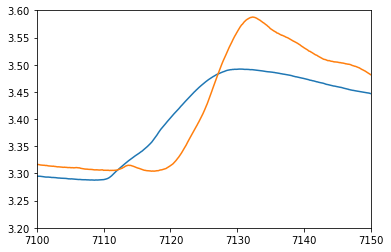

In [14]:
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlim(7100, 7150)
plt.ylim(3.2,3.6)

In [15]:
merged_spectra2['Process Values']['TR1 T [°C]']

38.37660688822965

In [16]:
merged_spectra1['Process Values']['TR1 T [°C]']

520.000071430733

(3.2, 3.5)

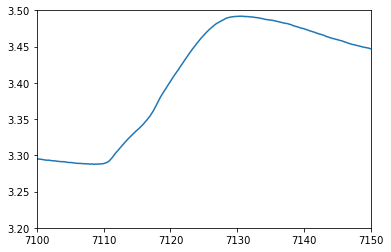

In [18]:
x = merged_spectra1['Absorption Spectra']['mu Sample'].energy[100:]
y = merged_spectra1['Absorption Spectra']['mu Sample'].mu[100:]
yerr = merged_spectra1['Absorption Spectra']['mu Sample'].mu_std[100:]

plt.plot(x,y)
#plt.errorbar(x,y, yerr = yerr, ecolor = 'k')
plt.xlim(7100, 7150)
plt.ylim(3.2,3.5)

In [19]:
merged_spectra1['Absorption Spectra']['mu Sample']

Attribute,Type
energy,ndarray
mu,ndarray
mu_std,ndarray


In [20]:
# Save Merge Spectra + Process Params

data = {
    'Energy': merged_spectra1['Absorption Spectra']['mu Sample'].energy[100:],
    'Sample mu': merged_spectra1['Absorption Spectra']['mu Sample'].mu[100:],
    'Ref mu': merged_spectra1['Absorption Spectra']['mu Reference'].mu[100:],
}

df = pd.DataFrame(data)

In [21]:
start = df['Energy'].iloc[0]
stop = df['Energy'].iloc[-1]
step = 0.25

new_E = np.arange(start, stop+step, step)

In [22]:
df.set_index('Energy', inplace = True)

In [23]:
df2 = fcts.interp_df(df,new_E)

In [24]:
df2

,Sample mu,Ref mu
Energy,,
6959.919682,3.472448,4.227431
6960.169682,3.472158,4.226900
6960.419682,3.471851,4.226643
6960.669682,3.471584,4.226221
6960.919682,3.471390,4.225979
...,...,...
7870.169682,2.629388,5.101262
7870.419682,2.629359,5.100546
7870.669682,2.629136,5.099433


In [25]:
output_dir = r'D:\UU QEXAFS Workup\Nina - BF31\Fe Edge\Up\Results\Step B'

merge_fname = r'State B post Reduction2'

process_fname = r'State B post Reduction - params'

In [27]:
# Save Merge Spectra
df2.to_csv(os.path.join(output_dir, merge_fname + '.csv'), sep=',', na_rep='', header=True, index=True)

# Save Process Params
merged_spectra1['Process Values'].to_csv(os.path.join(output_dir, process_fname + '.csv'), sep=',', na_rep='', header=True, index=False)